In [2]:
import argparse
import json
import os
import pickle
import zipfile
from itertools import chain

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Bidirectional, Embedding, Dropout, SpatialDropout1D, Dense, LSTM, \
    BatchNormalization, Input, Activation
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.ops.init_ops import Constant
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import tensorflow as tf
from tqdm import trange, tqdm

In [2]:
epochs = 50
BS = 64
LR = 0.001
train_dict = pickle.load(open("./data/train.pkl", 'rb'))
val_dict = pickle.load(open("./data/val.pkl", 'rb'))
test_dict = pickle.load(open("./data/test.pkl", 'rb'))

In [3]:
total_list = train_dict["word_seq"] + val_dict["word_seq"] + test_dict["word_seq"]
model = Word2Vec(total_list, size=300, window=5, min_count=1, workers=4)
# model.train(val_dict["word_seq"], total_examples=2950, epochs=5)
# model.train(test_dict["word_seq"], total_examples=2950, epochs=5)
print("Train word2vec model down.")

Train word2vec model down.


In [16]:
model.save("word2vec/word2vec_selftrained.wordvectors")

In [3]:
model = KeyedVectors.load("word2vec/word2vec_selftrained.wordvectors", mmap='r')

In [4]:
model.wv.vocab.keys()

dict_keys(['Protection', 'of', 'calves', 'against', 'fatal', 'enteric', 'colibacillosis', 'by', 'orally', 'administered', 'Escherichia', 'coli', 'K99', '-', 'specific', 'monoclonal', 'antibody', '.', 'A', '(', 'MCA', ')', 'to', 'enterotoxigenic', 'antigen', 'agglutinated', 'K99+', 'E', 'strains', 'B44', 'O9', ':', 'K30', ';', 'F41', 'H-', 'and', 'B41', 'O101', 'grown', 'at', '37', 'degrees', 'C', 'but', 'not', '18', 'C.', 'The', ',', 'which', 'was', 'characterized', 'as', 'immunoglobulin', 'G1', 'reacted', 'specifically', 'with', 'in', 'an', 'enzyme-linked', 'immunosorbent', 'assay', 'precipitated', 'radiolabeled', 'total', '45', 'colostrum', '-fed', '-deprived', 'were', 'used', 'three', 'separate', 'trials', 'determine', 'whether', 'the', 'K99-specific', 'would', 'prevent', 'diarrhea', 'caused', 'strain', 'Comparison', 'Cambodian', 'South', 'Korean', 'Health', 'Care', 'System', 'In', 'discussions', 'health', 'care', 'reform', 'system', 'is', 'held', 'up', 'a', 'possible', 'model', 'fo

In [5]:
encoded_dict = {}
count = 0
total = 0
word2vec_keys = model.wv.vocab.keys()
dimension = 300
for i in [train_dict, val_dict, test_dict]:
    for j in trange(len(i['word_seq'])):
        for word in i['word_seq'][j]:
            if word not in word2vec_keys:
                encoded_dict[word] = np.random.rand(1, dimension)[0]
                count += 1
                total += 1
            else:
                encoded_dict[word] = model.wv[word]
                total += 1
# Test how many words are found in glove and how many are randomly initialized
print("words not found {}".format(count))
print("words total {}".format(total))
print(len(encoded_dict))
if not os.path.exists('./word2vec'):
    os.mkdir('./word2vec/')
np.save("./word2vec/encoded_dict_{}d.npy".format(dimension), encoded_dict)

100%|████████████████████████████████████████████████████████████████████████████| 2950/2950 [00:01<00:00, 1972.29it/s]


words not found 0
words total 3776000
92288


In [6]:
encoded_word2id = {}
encoded_matrix = np.zeros((len(encoded_dict.keys()), dimension), dtype=float)
for i, word in enumerate(encoded_dict.keys()):
    encoded_word2id[word] = i
    encoded_matrix[i] = encoded_dict[word]
print(encoded_matrix.shape)
np.save("./word2vec/encoded_matrix_{}d.npy".format(dimension), encoded_matrix)

(92288, 300)


In [7]:
tag_list = list(set(chain(*train_dict["tag_seq"])))
tag_to_index_dict = {t: i for i, t in enumerate(tag_list)}
index_to_tag_dict = {i: t for i, t in enumerate(tag_list)}

In [8]:
if not os.path.exists('./lstm_model'):
    os.mkdir('./lstm_model/')
if not os.path.exists('./lstm_results'):
    os.mkdir('./lstm_results')
np.save("./lstm_model/model_tag2id_e{}_bs{}.npy".format(epochs, BS), tag_to_index_dict)
np.save("./lstm_model/model_id2tag_e{}_bs{}.npy".format(epochs, BS), index_to_tag_dict)

In [9]:
embedding_dim = dimension
num_words = len(encoded_dict)
input_length = 128
n_tags = len(tag_to_index_dict)
print(embedding_dim, num_words, input_length, n_tags)

300 92288 128 65


In [10]:
def get_bi_lstm_model():
    model = Sequential()
    model.add(Input(shape=(128,)))
    model.add(
        Embedding(num_words, embedding_dim, embeddings_initializer=Constant(encoded_matrix), input_length=input_length,
                  trainable=True))
    model.add(SpatialDropout1D(0.2))
    model.add(BatchNormalization())
    for _ in range(2):
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(BatchNormalization())
    model.add(Dropout(0.2))
    adam = Adam(lr=LR, beta_1=0.9, beta_2=0.999)
    model.add(Dense(units=n_tags))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

In [15]:
def train_model(X, y, val_X, val_y, model):
    hist = model.fit(X, y, batch_size=BS, verbose=1, epochs=epochs, validation_data=(val_X, val_y), shuffle=True)
    return hist


# build our model and print the summary
model_bi_lstm_lstm = get_bi_lstm_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 300)          27686400  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 128, 300)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 300)          1200      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 256)          439296    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 256)          1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128, 256)          394240    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 256)         

In [16]:
train_input = np.array(
    [[encoded_word2id[word] for word in train_dict['word_seq'][i]] for i in range(len(train_dict['word_seq']))])
val_input = np.array(
    [[encoded_word2id[word] for word in val_dict['word_seq'][i]] for i in range(len(val_dict['word_seq']))])
test_input = np.array(
    [[encoded_word2id[word] for word in test_dict['word_seq'][i]] for i in range(len(test_dict['word_seq']))])
train_output = np.array(
    [[tag_to_index_dict[tag] for tag in train_dict['tag_seq'][i]] for i in range(len(train_dict['tag_seq']))])
val_output = np.array(
    [[tag_to_index_dict[tag] for tag in val_dict['tag_seq'][i]] for i in range(len(val_dict['tag_seq']))])

# Check the shape of our input, their first dimension must be the same
print(train_input.shape, val_input.shape, test_input.shape)
print(train_output.shape, val_output.shape)

(23600, 128) (2950, 128) (2950, 128)
(23600, 128) (2950, 128)


In [18]:
history = train_model(train_input, train_output, val_input, val_output, model_bi_lstm_lstm)

Train on 23600 samples, validate on 2950 samples
Epoch 1/50
23600/23600 [==============================] - 406s 17ms/sample - loss: 2.7088 - accuracy: 0.7003 - val_loss: 2.1125 - val_accuracy: 0.8634
Epoch 2/50
23600/23600 [==============================] - 414s 18ms/sample - loss: 1.6889 - accuracy: 0.8687 - val_loss: 1.3843 - val_accuracy: 0.8827
Epoch 3/50
23600/23600 [==============================] - 410s 17ms/sample - loss: 1.1000 - accuracy: 0.9049 - val_loss: 0.9947 - val_accuracy: 0.8974
Epoch 4/50
23600/23600 [==============================] - 402s 17ms/sample - loss: 0.7347 - accuracy: 0.9243 - val_loss: 0.7194 - val_accuracy: 0.9117
Epoch 5/50
23600/23600 [==============================] - 397s 17ms/sample - loss: 0.5194 - accuracy: 0.9367 - val_loss: 0.5749 - val_accuracy: 0.9157
Epoch 6/50
23600/23600 [==============================] - 395s 17ms/sample - loss: 0.3892 - accuracy: 0.9450 - val_loss: 0.4962 - val_accuracy: 0.9189
Epoch 7/50
23600/23600 [=====================

In [17]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
sns.set_style(style="darkgrid")
sns.set(font_scale=1.75)
plt.rcParams["figure.figsize"] = (30, 15)

mpl.use('Agg')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
plt.savefig(
    './lstm_results/accuracy_BS{}E{}LR{}_{}d_{}layer.png'.format(BS, epochs, LR, dimension,
                                                                     2))
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
plt.savefig(
    './lstm_results/model_loss_BS{}E{}LR{}_{}d_{}layers.png'.format(BS, epochs, LR,
                                                                        dimension, 2))
print("save images down.")

save images down.


In [20]:
np.save(
    './lstm_results/model_results_val_BS{}E{}LR{}_{}d_{}layers.npy'.format(BS, epochs, LR,
                                                                               dimension, 2),
    history.history['val_accuracy'])
print("save history validation data down.")

save history validation data down.


In [21]:
answer = pandas.DataFrame(columns=['id', 'labels'])
answer['id'] = test_dict['id']

# Predict on the test dict and save it to answer csv file
predict = model_bi_lstm_lstm.predict(test_input)
for i in range(len(answer)):
    sentence_tag = []
    for j in range(128):
        tag = index_to_tag_dict[np.argmax(predict[i][j])]
        sentence_tag.append(tag)
    answer.loc[i, 'labels'] = json.dumps(sentence_tag)
answer.to_csv(
    './lstm_results/answer_BS{}E{}LR{}_{}d_{}layers.csv'.format(BS, epochs, LR, dimension,
                                                                    2), index=True)
print("save results csv down.")

save results csv down.


In [26]:
val_acc = np.load(
    './lstm_results/model_results_val_BS{}E{}LR{}_{}d_{}layers.npy'.format(BS, epochs, LR,
                                                                               dimension, 2))
print("best validation accuracy: {}\nfinal validation accuracy: {}".format(max(val_acc),val_acc[-1]))

best validation accuracy: 0.9267611503601074
final validation accuracy: 0.925378680229187


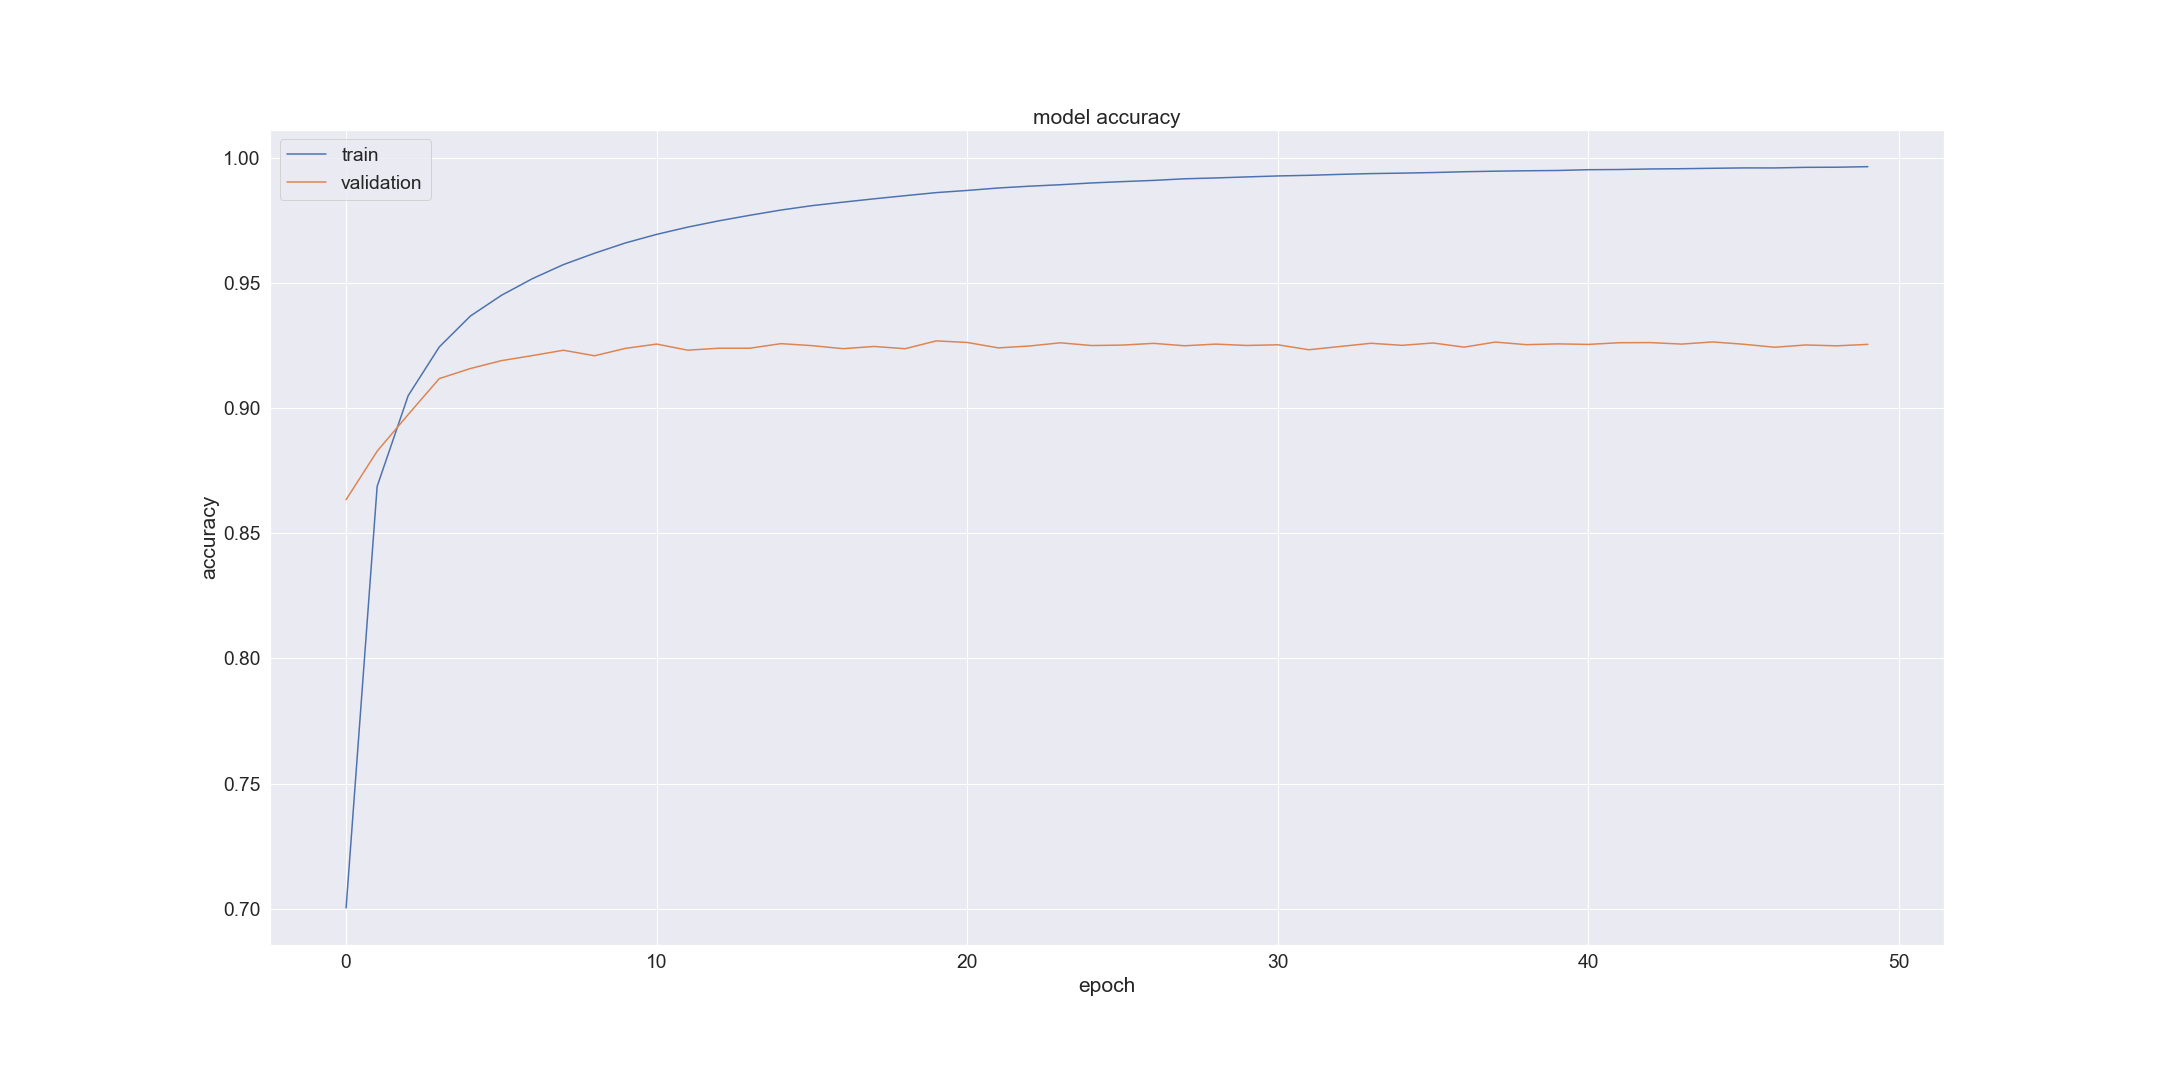

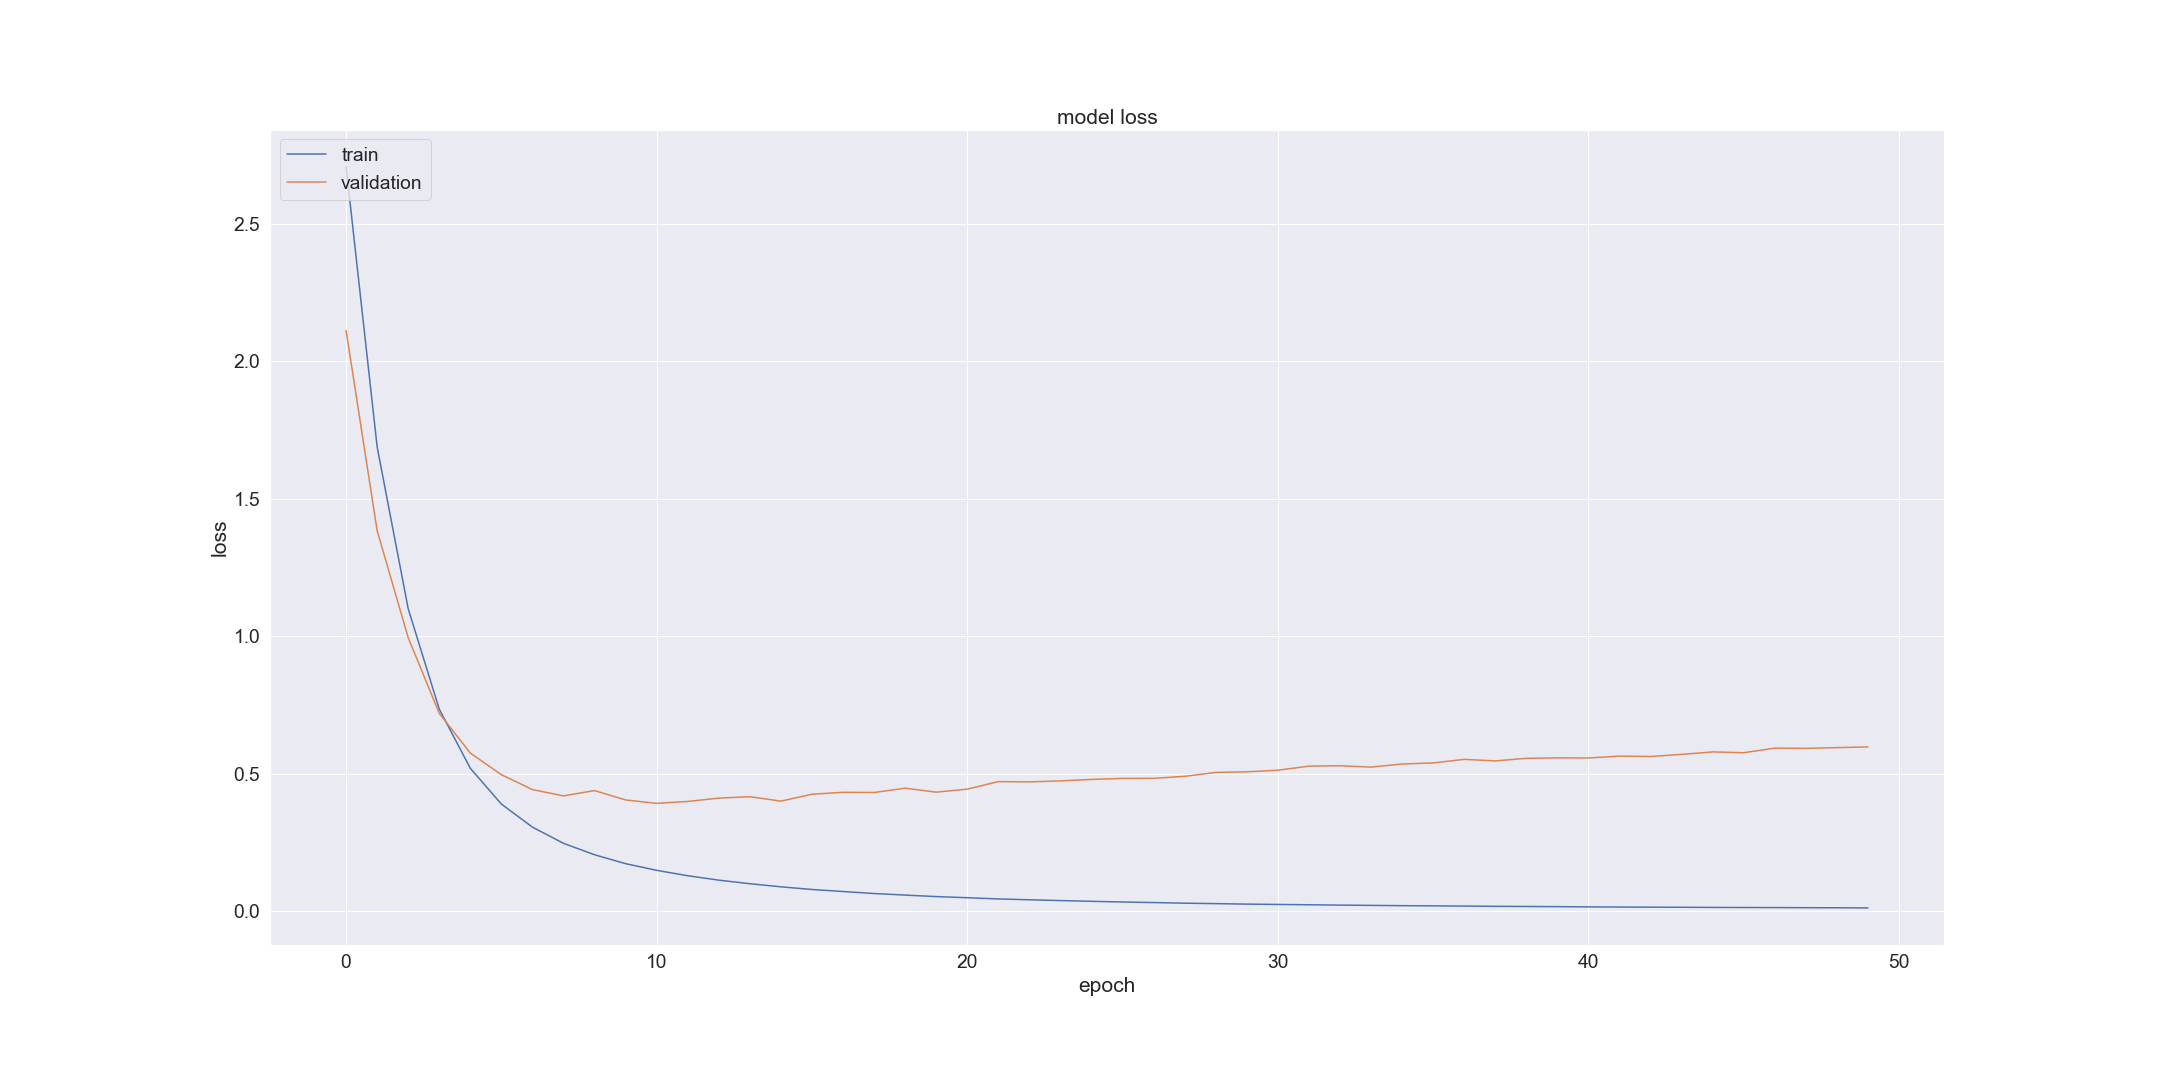

## Another word2vec model with pretrained google-news-300

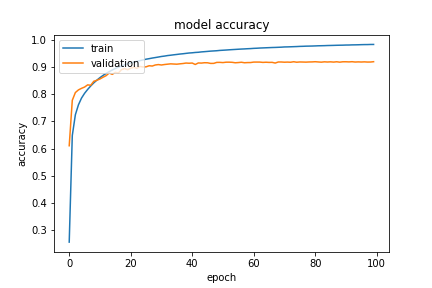

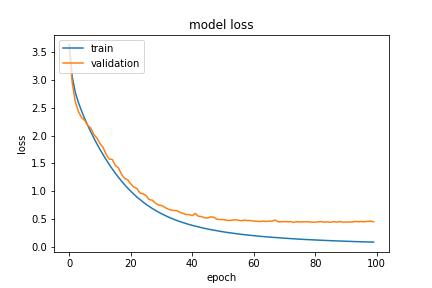

In [3]:
val_acc = np.load(
    './lstm_results/pretrained_word2vec_valacc.npy')
print("best validation accuracy: {}\nfinal validation accuracy: {}".format(max(val_acc),val_acc[-1]))

best validation accuracy: 0.9201615452766418
final validation accuracy: 0.9201589226722717
